### Next-Frame Video Prediction with Convolutional LSTMs

- 시계열 영상 데이터를 입력받아 다음 스텝-프레임을 예측하는 모델.  
- abnormal detection에 사용.  


사용예:  
1. Cyber-Intrusion Detection: 컴퓨터 시스템 상에 침입을 탐지  
2. Fraud Detection: 보험, 신용, 금융 관련 데이터에서 불법 행위를 검출  
3. Malware Detection: Malware(악성코드)를 검출  
4. Medical Anomaly Detection: 의료 영상, 뇌파 기록 등  
5. Social Networks Anomaly Detection: Social Network 상의 이상치들을 검출  
6. Log Anomaly Detection: 시스템이 기록한 log를 보고 실패 원인을 추적하는 사례.  
7. IoT Big-Data Anomaly Detection: 사물 인터넷에서 생성된 데이터에 대해 이상치를 탐지하는 사례  
8. Industrial Anomaly Detection: 산업 속 제조업 데이터에 대한 이상치를 탐지  
9. Video Surveillance: 비디오 영상에서 이상한 행동이 발생하는 것을 모니터링.  
     - 항만에서 배 항로를 확인하고, 향후 사고 예측.  
     - 위성 데이터-기후 데이터를 통한 일기예보 예측.  
     - ConvLSTM을 이용한 도로 구간 속도(속도, 요일 멀티입력)  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox, VBox

from pympler import asizeof
import psutil
import os, sys

print(tf.__version__)
data_type = "float32"

2.10.0


In [ ]:
def process_mem_usage(pid = None):
    '''
    process memory usage: bytes
    '''
    if pid is None:
        pid = os.getpid()

    current_process = psutil.Process(pid)
    mem_usage = current_process.memory_info()[0]
    print("pid:", pid, " mem:", int(mem_usage/1024/1024))
    # return mem_usage

def obj_sizeof(obj, div=1024*1024):
    
    sz = asizeof.asizeof(obj)//div
    return sz
    # if sz is None:
    #     dim = len(obj.shape)
    #     sz = obj.shape[0]
    #     for i in range(1, dim):
    #         sz = sz * obj.shape[i]

    # print(sz)

process_mem_usage()

pid: 7199  mem: 1343


In [ ]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
fpath = '/home/evergrin/python/notebook/data/next_frame/moving_mnist.npy'

# (20, 10000, 64, 64) 20frame, 10000 sample, 64w, 64h
dataset = np.load(fpath)
print(dataset.shape, dataset.dtype)

process_mem_usage()

(20, 10000, 64, 64) uint8
pid: 7199  mem: 1343


In [ ]:

# Swap the axes representing the number of frames and number of data samples.
#(10000, 20, 64, 64)
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:100, ...]
# Add a channel dimension since the images are grayscale.
# (2, 20, 64, 64, 1) 5dim: samples, frames, width, height, channels
dataset = np.expand_dims(dataset, axis=-1)
print(dataset.shape)

(100, 20, 64, 64, 1)


In [ ]:
print(np.float64(1).nbytes)
obj_sizeof(dataset)

8


781

In [ ]:

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :].astype(data_type)
    y = data[:, 1 : data.shape[1], :, :].astype(data_type)
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape), y_train.dtype)
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape), y_val.dtype)
process_mem_usage()

Training Dataset Shapes: (90, 19, 64, 64, 1), (90, 19, 64, 64, 1) float32
Validation Dataset Shapes: (10, 19, 64, 64, 1), (10, 19, 64, 64, 1) float32
pid: 7199  mem: 1347


Displaying frames for example 70.


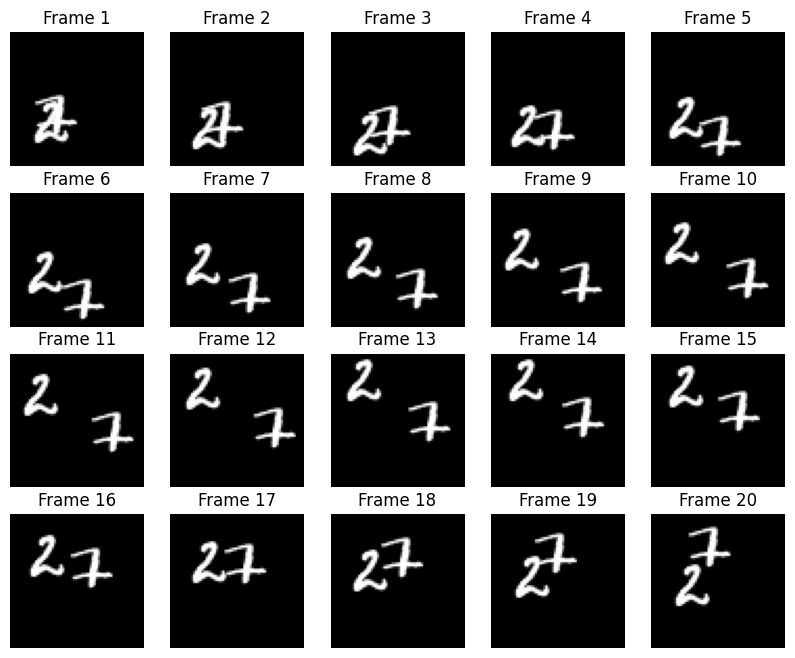

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

Model Construction
To build a Convolutional LSTM model, we will use the ConvLSTM2D layer, which will accept inputs of shape (batch_size, num_frames, width, height, channels), and return a prediction movie of the same shape.

In [ ]:
print(x_train.shape[2:])

(64, 64, 1)


##### ConvLSTM2D:  
 - dataformat : channels_last  (samples, time, rows, cols, channels)   
 - time만큼 step()함수를 실행.  
 - input, hidden입력에 대해 4개의 gate마다 convolution실행.  
 - recurrent_activation='hard_sigmoid'  
 - return_sequence=True: False인 경우 다음 lstm으로 4차원이 전달되어 에러 발생하므로 True사용.    
 - padding="same"을 사용, False인 경우 input Conv시 크기가 달라 에러발생  
 - stateful=False, sample 마지막 frame의 상태가 다음 sample처음 입력시 사용.  


In [ ]:
# Construct the input layer with no definite frame size.(64, 64, 1)
inp = layers.Input(shape=(None, *x_train.shape[2:]), dtype=data_type)

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.

lstm1 = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    dtype=data_type,
)
lstm2 = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    dtype=data_type,
)
lstm3 = x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    dtype=data_type,
)
conv1 = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same",
    dtype=data_type,
)

x = lstm1(inp)
x = layers.BatchNormalization(dtype=data_type)(x)
x = lstm2(x)
x = layers.BatchNormalization(dtype=data_type)(x)
x = lstm3(x)
x = conv1(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

In [ ]:
def show_layer_info(laier):
    print(f"layer: {laier.name}({laier.dtype})")
    print(f"  input : {laier.input.shape}")
    print(f"  output: {laier.output.shape}")
    total_weight_size = 0
    for idx, weight in enumerate(laier.weights):
        total_weight_size = total_weight_size + obj_sizeof(weight, 1)
        # print(f"weight_{idx} :", weight.shape, obj_sizeof(weight, 1))
    print(f"  weight size: {total_weight_size}")


show_layer_info(lstm1)
show_layer_info(lstm2)
show_layer_info(lstm3)
show_layer_info(conv1)

layer: conv_lstm2d_12(float32)
  input : (None, None, 64, 64, 1)
  output: (None, None, 64, 64, 64)
  weight size: 15000
layer: conv_lstm2d_13(float32)
  input : (None, None, 64, 64, 64)
  output: (None, None, 64, 64, 64)
  weight size: 15008
layer: conv_lstm2d_14(float32)
  input : (None, None, 64, 64, 64)
  output: (None, None, 64, 64, 64)
  weight size: 15008
layer: conv3d_4(float32)
  input : (None, None, 64, 64, 64)
  output: (None, None, 64, 64, 1)
  weight size: 9944


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_12 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256   
                                                                 
 batch_normalization_2 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168   
                                                                 
 batch_normalization_3 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                           

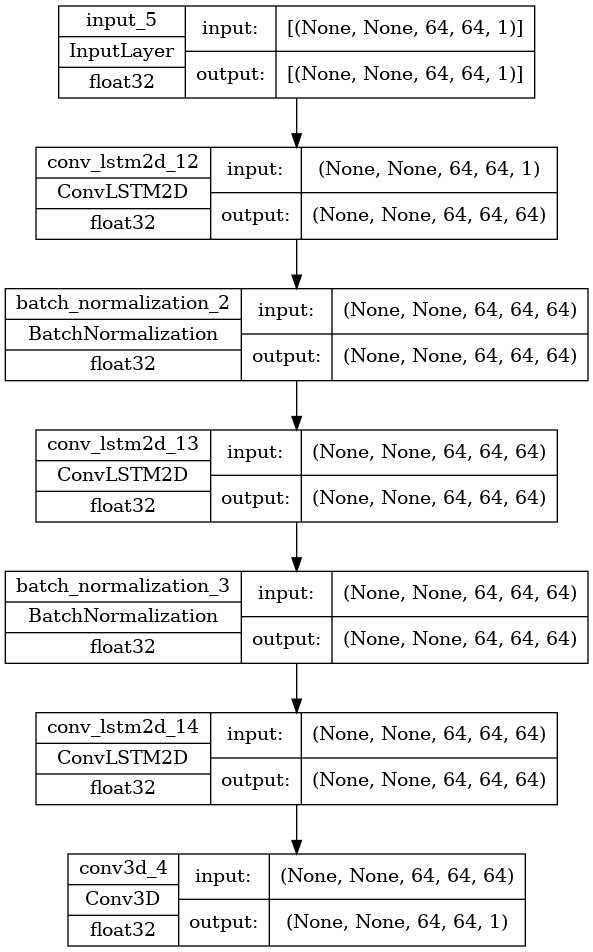

In [ ]:
from tensorflow.keras.utils import plot_model 

print(model.summary())
plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode='min')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1)

# Define modifiable training hyperparameters.
epochs = 1
batch_size = 1

process_mem_usage()
# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)
process_mem_usage()


pid: 7199  mem: 1392
90/90 [==============================] - 628s 7s/step - loss: 0.1064 - val_loss: 0.3349 - lr: 0.0010
pid: 7199  mem: 2586


Frame Prediction Visualizations
With our model now constructed and trained, we can generate some example frame predictions based on a new video.

We'll pick a random example from the validation set and then choose the first ten frames from them. From there, we can allow the model to predict 10 new frames, which we can compare to the ground truth frame predictions.

##### model 1epoch 실행시 프로세스 메모리 사용량 비교:

    - dataset:100개, epoch:1회, batch:1, float64 : 1407 Mb  
    - dataset:100개, epoch:1회, batch:5, float64 : 3616 Mb  
    - dataset:100개, epoch:1회, batch:1, float16 : 너무 느려 확인안됨. 
    - dataset:100개, epoch:1회, batch:1, float32 : 1326 Mb  

##### ConvLSTM 메모리 추정치 (float64):  
입력 data 크기(20frame) : 640Kb  
total layer weights : 55000     
1step input-conv outputs : 64 * 64 * 64channel * 8byte * 4ea = 8Mb  
1step recurrent-conv outputs : 64 * 64 * 64channel * 8byte * 4ea = 8Mb  
19step ConvLSTM outputs: 16Mb * 3 * 19 = 912Mb


In [ ]:
# 학습된 모델을 불러옴.
# model = keras.models.load_model("/home/evergrin/python/notebook/data/next_frame/model_d1000_e20")

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]


In [ ]:
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:2, ...]
frames.shape

(2, 64, 64, 1)

In [ ]:
frames.shape
frames2 = np.expand_dims(frames, axis=0)
frames2.shape

(1, 2, 64, 64, 1)

In [ ]:
new_prediction = model.predict(frames2)
new_prediction.shape

1/1 [==============================] - 1s 1s/step


(1, 2, 64, 64, 1)

In [ ]:
new_prediction = np.squeeze(new_prediction, axis=0)
new_prediction.shape

(2, 64, 64, 1)

In [ ]:
new_prediction = new_prediction[-1, ...]
print(new_prediction.shape)
predicted_frame = np.expand_dims(new_prediction, axis=0)
predicted_frame.shape

(64, 64, 1)


(1, 64, 64, 1)

In [ ]:
print(frames.shape)
frames = np.concatenate((frames, predicted_frame), axis=0)
frames.shape

(2, 64, 64, 1)


(3, 64, 64, 1)

1/1 [==============================] - 2s 2s/step


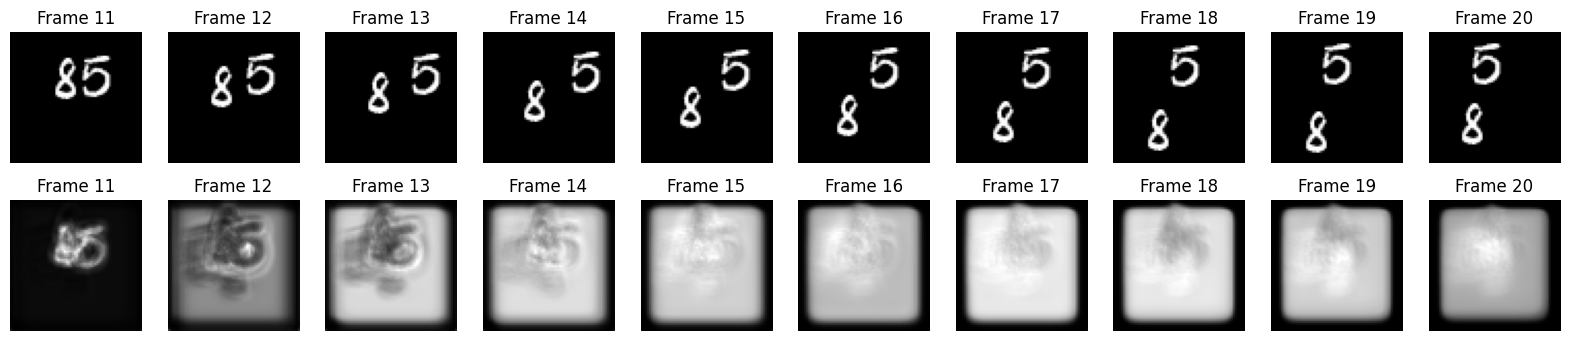

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    
    # expanded: (10, 64, 64, 1)
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    # (1, 10, 64, 64, 1)
    
    new_prediction = np.squeeze(new_prediction, axis=0)
    # (10, 64, 64, 1)
    
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # (1, 64, 64, 1)
    
    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
    # (10, 64, 64, 1) -> (11, 64, 64, 1)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

Predicted Videos
Finally, we'll pick a few examples from the validation set and construct some GIFs with them to see the model's predicted videos.

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...] # 11부터 - 20 frame까지 입력을 늘려가면서 예측함.
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())


1/1 [==============================] - 2s 2s/step


In [ ]:

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [ 
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction


1/1 [==============================] - 0s 192ms/step


Text(0.5, 1.0, '1 frame input')

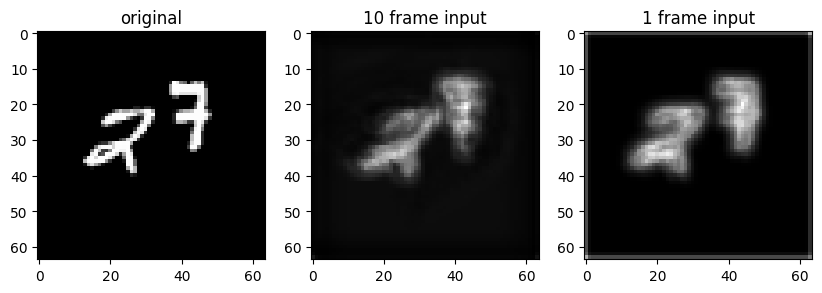

In [ ]:
# 10frame / 1frame 입력시 predict비교. 

example = examples[1]

# 10 frame(0..9) input predict
frames10 = example[: 10, ...]
pred_10 = model.predict(np.expand_dims(frames10, axis=0))
img_10 = pred_10[0][9]

# 1 frame(9) input predict
frame1 = np.expand_dims(example[9: 10, ...], axis=0)
pred_1 = model.predict(frame1)
img_1 = pred_1[0][0]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(frame1[0][0], cmap='gray')
axes[0].set_title("original")
axes[1].imshow(img_10, cmap="gray")
axes[1].set_title("10 frame input")
axes[2].imshow(img_1, cmap="gray")
axes[2].set_title("1 frame input")

# frame 10개를 넣어 예측한 것과 1개를 넣어 예측한것은 다르다.  
# frame 10개를 넣어 예측한 것이 더 디테일하다.  

##### References:  
    - convlstm paper: https://arxiv.org/pdf/1506.04214.pdf  
    - src code : https://github.com/keras-team/keras/tree/master/keras/layers/rnn  
    - api: https://www.tensorflow.org/api_docs/python/tf/keras/layers/ConvLSTM2D
    - paper설명 https://study-grow.tistory.com/entry/논문-읽기-ConvLSTM-이해하기    
    - LSTM설명: https://tykimos.github.io/2017/04/09/RNN_Getting_Started/  
    - LSTM설명: https://wikidocs.net/106473  
    - hard-sigmoid: https://paperswithcode.com/method/hard-sigmoid  
    - 예제설명: https://velog.io/@cosmicdev/Next-Frame-Video-Prediction-with-Convolutional-LSTMs